In [1]:
# Import Dependencies
import json
import requests
import gmaps
from config import api_key
from config import gkey
from config import fskey
from pprint import pprint
import pandas as pd
from datetime import date
from datetime import timedelta
import requests
import urllib
from urllib.request import urlopen
import json
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress
import numpy as np
import geopy.distance as gp
import warnings
warnings.filterwarnings('ignore')

# Food Deserts

A Food Desert is an area that has limited access to affordable and nutritious food. Food deserts tend to be inhabited by low-income residents with reduced mobility; this makes them a less attractive market for large supermarket chains. Food deserts lack suppliers of fresh foods, such as meats, fruits, and vegetables. Instead, the available foods are often processed and high in sugar and fats, which are known contributors to the proliferation of obesity in the U.S.

### Beginning the data-gathering process

We found that the Percentage of Free or Reduced Lunches (Percent_FRL) at school is a strong indicator of poverty in an area:
https://nces.ed.gov/blogs/nces/post/free-or-reduced-price-lunch-a-proxy-for-poverty

Using this metric, we identified 90 schools across 7 counties of Georgia with Percent_FRL of >= 92%. We collected these school names, physical addresses and the their Percent_FRL in a CSV file.

### Approach
1. Get the name and addresses of all the schools which have the >90% FRL (free-reduced lunch) (%FRL is used as an indicator of poverty).
2. Find out the number of grocery stores within 5-10 miles of these schools (usually people live near the schools and higher percentage FRL means that the neighborhood is poor).
3. Create a Heat Map these grocery stores.
4. Find out any Fast Food joints / Dollar Stores within 5 miles of these locations. Usually in Food Deserts there is proliferation of these establishments selling processed foods.
5. Creat a Heat Map these Fast Food places / Dollar Stores.

In [2]:
infile = pd.read_csv("../Datasets/GA_County_Data.csv")
county_df = pd.DataFrame(infile)
county_df

,County_ID,County_Name,Per_Capita_Income,Percent_FRL,Latitude,Longitude
0,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206
1,631,Clayton County,"32,702.00",92.55,33.506014,-84.357362
2,633,Cobb County,"63,214.00",39.14,33.962944,-84.544548
3,634,Coffee County,"35,507.00",87.34,31.508705,-82.850724
4,635,Colquitt County,"37,418.00",86.21,31.190741,-83.789843
5,644,DeKalb County,"56,428.00",68.56,33.774350,-84.297124
6,650,Echols County,"31,945.00",91.26,30.703350,-83.027601
7,658,Forsyth County,"67,859.00",13.68,34.206598,-84.138697
8,660,Fulton County,"95,683.00",42.17,33.758231,-84.391101
9,667,Gwinnett County,"46,886.00",50.30,33.966996,-83.994210


## Getting Coordinates of the Counties

In [128]:
grocery_stores = []
errors = []
current_record = ''
for row in county_df.itertuples():   
   
    County_ID = row.County_ID
    County_Name = row.County_Name
    County_Income = row.Per_Capita_Income
    Poverty_Rate = row.Percent_FRL  
    County_Lat = str(row.Latitude)
    County_Long = str(row.Longitude) 
    radius = '8000'
    category = '17069'
    limit = '25'
    
    url = "https://api.foursquare.com/v3/places/search"

    query_url = url + "?ll=" + County_Lat + "%2C"+ County_Long + "&radius="+ radius+"&categories="+category+ "&limit="+ limit

    headers = {
        "Accept": "application/json",
        "Authorization": fskey
    }

    response = requests.request("GET", query_url, headers=headers).json()

    try:
            i = 0
            for r in response['results']:
                if len(response['results'][i]['chains']) > 0:
                    Store_Lat = response['results'][i]['geocodes']['main']['latitude']
                    Store_Long = response['results'][i]['geocodes']['main']['longitude']
                    Store_Name = response['results'][i]['name']
                    Store_Address = response['results'][i]['location']['address'] +', '+ response['results'][0]['location']['locality'] \
                    +', '+ response['results'][i]['location']['region'] +', '+ response['results'][0]['location']['postcode']
                    coords_1 = (County_Lat, County_Long)
                    coords_2 = (Store_Lat, Store_Long)
                    Dist = (gp.distance(coords_1, coords_2).km) * 0.621371

                    current_record = [County_ID, County_Name, County_Income, Poverty_Rate, County_Lat, County_Long,\
                                        Store_Name, Store_Lat, Store_Long, Store_Address, Dist]

                    grocery_stores.append(current_record)
        
                i = i + 1

    except IndexError:
        errors.append('Index Out of Range')    
    


grocery_stores_df = pd.DataFrame(grocery_stores, columns=['County_ID', 'County_Name', 'County_Income', 'Poverty_Rate', 'County_Lat', 'County_Long', 'Store_Name',\
            'Store_Lat','Store_Long', 'Store_Address','Dist'])
grocery_stores_df

,County_ID,County_Name,County_Income,Poverty_Rate,County_Lat,County_Long,Store_Name,Store_Lat,Store_Long,Store_Address,Dist
0,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Kroger,33.153393,-83.272163,"2809 N Columbia St, Milledgeville, GA, 31061",5.573850
1,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Piggly Wiggly,33.071917,-83.225724,"731 S Wayne St, Milledgeville, GA, 31061",0.673637
2,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Piggly Wiggly,33.094579,-83.240763,"1310 N Columbia St, Milledgeville, GA, 31061",1.160724
3,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Aldi,33.107343,-83.254181,"1978 N Columbia St, Milledgeville, GA, 31061",2.334586
4,631,Clayton County,"32,702.00",92.55,33.506014,-84.357362,Publix,33.561696,-84.325135,"2035 Mount Zion Rd, Jonesboro, GA, 30236",4.264537
...,...,...,...,...,...,...,...,...,...,...,...
104,692,Lowndes County,"41,117.00",43.76,30.84189,-83.27888,City Market,30.831068,-83.278709,"101 N Patterson St, Valdosta, GA, 31602",0.745587
105,692,Lowndes County,"41,117.00",43.76,30.84189,-83.27888,Piggly Wiggly,30.859578,-83.279118,"2111 Bemiss Rd, Valdosta, GA, 31602",1.218599
106,699,Meriwether County,"39,121.00",88.02,33.029043,-84.713045,Piggly Wiggly,33.026160,-84.712237,"570 S Talbotton St, Greenville, GA, 30222",0.204138
107,750,Washington County,"39,151.00",85.62,32.983578,-82.811602,Harveys Supermarket,32.978821,-82.812098,"306 S Harris St, Sandersville, GA, 31082",0.329081


In [119]:
dollar_stores = []
errors = []
current_record = ''
for row in county_df.itertuples():   

    County_ID = row.County_ID
    County_Name = row.County_Name
    County_Income = row.Per_Capita_Income
    Poverty_Rate = row.Percent_FRL  
    County_Lat = str(row.Latitude)
    County_Long = str(row.Longitude) 
    radius = '8000'
    category = '17034'
    limit = '25'
    
    url = "https://api.foursquare.com/v3/places/search"

    query_url = url + "?ll=" + County_Lat + "%2C"+ County_Long + "&radius="+ radius+"&categories="+category+ "&limit="+ limit

    headers = {
        "Accept": "application/json",
        "Authorization": fskey
    }

    response = requests.request("GET", query_url, headers=headers).json()

    try:
            i = 0
            for r in response['results']:
                Store_Lat = response['results'][i]['geocodes']['main']['latitude']
                Store_Long = response['results'][i]['geocodes']['main']['longitude']
                Store_Name = response['results'][i]['name']
                Store_Address = response['results'][i]['location']['address'] +', '+ response['results'][0]['location']['locality'] \
                +', '+ response['results'][i]['location']['region'] +', '+ response['results'][0]['location']['postcode']
                coords_1 = (County_Lat, County_Long)
                coords_2 = (Store_Lat, Store_Long)
                Dist = (gp.distance(coords_1, coords_2).km) * 0.621371

                current_record = [County_ID, County_Name, County_Income, Poverty_Rate, County_Lat, County_Long,\
                                    Store_Name, Store_Lat, Store_Long, Store_Address, Dist]

                dollar_stores.append(current_record)
        
                i = i + 1

    except IndexError:
        errors.append('Index Out of Range')    
    


dollar_stores_df = pd.DataFrame(dollar_stores, columns=['County_ID', 'County_Name', 'County_Income', 'Poverty_Rate', 'County_Lat', 'County_Long', 'Store_Name',\
            'Store_Lat','Store_Long', 'Store_Address','Dist'])
dollar_stores_df

,County_ID,County_Name,County_Income,Poverty_Rate,County_Lat,County_Long,Store_Name,Store_Lat,Store_Long,Store_Address,Dist
0,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Dollar General,33.097504,-83.260336,"207 Roberson Mill Rd NE, Milledgeville, GA, 31061",2.166930
1,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Dollar General,33.096256,-83.242935,"1550 N Columbia St, Milledgeville, GA, 31061",1.330004
2,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Family Dollar,33.072968,-83.225646,"641 S Wayne St, Milledgeville, GA, 31061",0.604170
3,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Dollar General,33.038010,-83.235249,"2622 Irwinton Rd, Milledgeville, GA, 31061",3.022496
4,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Dollar General,33.080799,-83.166300,"102 Robins Dr NE, Milledgeville, GA, 31061",3.591815
...,...,...,...,...,...,...,...,...,...,...,...
214,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,Fred's Super Dollar,33.730710,-82.715432,"923 N Bypass E, Washington, GA, 30673",1.797769
215,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,Maxway,33.726262,-82.717777,"126 Washington Plz, Washington, GA, 30673",1.903505
216,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,Family Dollar Store,33.725704,-82.718201,"164 Bi-Lo Plz, Washington, GA, 30673",1.915494
217,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,Maxway 334,33.727368,-82.718226,"126 Washington Plz, Washington, GA, 30673",1.830393


In [108]:
fastfoodplace = []
errors = []
current_record = ''
for row in county_df.itertuples():   

    County_ID = row.County_ID
    County_Name = row.County_Name
    County_Income = row.Per_Capita_Income
    Poverty_Rate = row.Percent_FRL  
    County_Lat = str(row.Latitude)
    County_Long = str(row.Longitude) 
    radius = '8000'
    category = '13145'
    limit = '25'
    
    url = "https://api.foursquare.com/v3/places/search"

    query_url = url + "?ll=" + County_Lat + "%2C"+ County_Long + "&radius="+ radius+"&categories="+category+ "&limit="+ limit

    headers = {
        "Accept": "application/json",
        "Authorization": fskey
    }

    response = requests.request("GET", query_url, headers=headers).json()

    try:
            i = 0
            for r in response['results']:
                Store_Lat = response['results'][i]['geocodes']['main']['latitude']
                Store_Long = response['results'][i]['geocodes']['main']['longitude']
                Store_Name = response['results'][i]['name']
                Store_Address = response['results'][i]['location']['address'] +', '+ response['results'][0]['location']['locality'] \
                +', '+ response['results'][i]['location']['region'] +', '+ response['results'][0]['location']['postcode']
                coords_1 = (County_Lat, County_Long)
                coords_2 = (Store_Lat, Store_Long)
                Dist = (gp.distance(coords_1, coords_2).km) * 0.621371

                current_record = [County_ID, County_Name, County_Income, Poverty_Rate, County_Lat, County_Long,\
                                    Store_Name, Store_Lat, Store_Long, Store_Address, Dist]

                fastfoodplace.append(current_record)
        
                i = i + 1

    except IndexError:
        errors.append('Index Out of Range')    
    


fastfoodplace_df = pd.DataFrame(fastfoodplace, columns=['County_ID', 'County_Name', 'County_Income', 'Poverty_Rate', 'County_Lat', 'County_Long', 'Store_Name',\
            'Store_Lat','Store_Long', 'Store_Address','Dist'])

fastfoodplace_df


,County_ID,County_Name,County_Income,Poverty_Rate,County_Lat,County_Long,Store_Name,Store_Lat,Store_Long,Store_Address,Dist
0,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Chick-Fil-A,33.100634,-83.248192,"1730 N Columbia St, Milledgeville, GA, 31061",1.757580
1,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Cook Out,33.105562,-83.251215,"1893 N Columbia St, Milledgeville, GA, 31061",2.130436
2,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Chick-Fil-A,33.080809,-83.231883,"231 W Hancock St, Milledgeville, GA, 31061",0.218098
3,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Freddy's Frozen Custard & Steakburgers,33.099372,-83.245621,"1671 N Columbia St, Milledgeville, GA, 31061",1.594763
4,605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,Firehouse Subs,33.107465,-83.252706,"1909 N Columbia St, Milledgeville, GA, 31061",2.286897
...,...,...,...,...,...,...,...,...,...,...,...
253,750,Washington County,"39,151.00",85.62,32.983578,-82.811602,Hardee's,32.952455,-82.809477,"195 Walmart Cir, Sandersville, GA, 31082",2.148286
254,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,Subway,33.728224,-82.719052,"918 E Robert Toombs Ave, Washington, GA, 30673",1.754926
255,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,Zaxby's,33.727722,-82.716401,"1011 E Robert Toombs Ave, Washington, GA, 30673",1.888133
256,757,Wilkes County,"42,093.00",94.17,33.746467,-82.740314,McDonald's,33.726594,-82.716135,"1018 E Robert Toombs Avenue Atlanta Fld, Washi...",1.953051


In [129]:
gp_grocery_stores_df = grocery_stores_df.groupby(['County_ID','County_Name'])

total_grocery_stores = gp_grocery_stores_df['Store_Name'].count()
print(total_grocery_stores)

County_ID  County_Name      
605        Baldwin County        4
631        Clayton County        9
633        Cobb County          15
634        Coffee County         2
635        Colquitt County       3
644        DeKalb County        17
658        Forsyth County       10
660        Fulton County        20
667        Gwinnett County      18
683        Johnson County        1
692        Lowndes County        7
699        Meriwether County     1
750        Washington County     1
757        Wilkes County         1
Name: Store_Name, dtype: int64


In [130]:
gp_dollar_stores_df = dollar_stores_df.groupby(['County_ID','County_Name'])

total_dollar_stores = gp_dollar_stores_df['Store_Name'].count()
print(total_dollar_stores)

County_ID  County_Name      
605        Baldwin County       14
631        Clayton County       25
633        Cobb County          25
634        Coffee County        15
635        Colquitt County      11
644        DeKalb County        25
658        Forsyth County       15
660        Fulton County        25
667        Gwinnett County      25
683        Johnson County        2
692        Lowndes County       22
699        Meriwether County     3
703        Montgomery County     2
750        Washington County     5
757        Wilkes County         5
Name: Store_Name, dtype: int64


In [122]:
gp_fastfoodplace_df = fastfoodplace_df.groupby(['County_ID','County_Name'])

total_fastfoodplace = gp_fastfoodplace_df['Store_Name'].count()
print(total_fastfoodplace)

County_ID  County_Name      
605        Baldwin County       25
631        Clayton County       25
633        Cobb County          25
634        Coffee County        24
635        Colquitt County      19
644        DeKalb County        25
658        Forsyth County       25
660        Fulton County        25
667        Gwinnett County      25
683        Johnson County        1
692        Lowndes County       25
703        Montgomery County     2
750        Washington County     8
757        Wilkes County         4
Name: Store_Name, dtype: int64


In [140]:
county_summary_df = pd.DataFrame({"Total_Grocery_Stores": total_grocery_stores,
                                    "Total_Dollar_Stores": total_dollar_stores,
                                     "Total_Fast_Food_Places": total_fastfoodplace})
# county_summary_df.set_index('County_ID')

county_summary_df

,,Total_Grocery_Stores,Total_Dollar_Stores,Total_Fast_Food_Places
County_ID,County_Name,,,
605,Baldwin County,4.0,14,25.0
631,Clayton County,9.0,25,25.0
633,Cobb County,15.0,25,25.0
634,Coffee County,2.0,15,24.0
635,Colquitt County,3.0,11,19.0
644,DeKalb County,17.0,25,25.0
658,Forsyth County,10.0,15,25.0
660,Fulton County,20.0,25,25.0
667,Gwinnett County,18.0,25,25.0


In [147]:
# county_df = county_df.set_index('County_ID')
county_df

,County_Name,Per_Capita_Income,Percent_FRL,Latitude,Longitude
County_ID,,,,,
605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206
631,Clayton County,"32,702.00",92.55,33.506014,-84.357362
633,Cobb County,"63,214.00",39.14,33.962944,-84.544548
634,Coffee County,"35,507.00",87.34,31.508705,-82.850724
635,Colquitt County,"37,418.00",86.21,31.190741,-83.789843
644,DeKalb County,"56,428.00",68.56,33.774350,-84.297124
650,Echols County,"31,945.00",91.26,30.703350,-83.027601
658,Forsyth County,"67,859.00",13.68,34.206598,-84.138697
660,Fulton County,"95,683.00",42.17,33.758231,-84.391101


In [149]:
county_stores_df = county_df.merge(county_summary_df[['Total_Grocery_Stores','Total_Dollar_Stores','Total_Fast_Food_Places']], on = 'County_ID', how = 'left')
county_stores_df

,County_Name,Per_Capita_Income,Percent_FRL,Latitude,Longitude,Total_Grocery_Stores,Total_Dollar_Stores,Total_Fast_Food_Places
County_ID,,,,,,,,
605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,4.0,14.0,25.0
631,Clayton County,"32,702.00",92.55,33.506014,-84.357362,9.0,25.0,25.0
633,Cobb County,"63,214.00",39.14,33.962944,-84.544548,15.0,25.0,25.0
634,Coffee County,"35,507.00",87.34,31.508705,-82.850724,2.0,15.0,24.0
635,Colquitt County,"37,418.00",86.21,31.190741,-83.789843,3.0,11.0,19.0
644,DeKalb County,"56,428.00",68.56,33.774350,-84.297124,17.0,25.0,25.0
650,Echols County,"31,945.00",91.26,30.703350,-83.027601,NaN,NaN,NaN
658,Forsyth County,"67,859.00",13.68,34.206598,-84.138697,10.0,15.0,25.0
660,Fulton County,"95,683.00",42.17,33.758231,-84.391101,20.0,25.0,25.0


In [151]:
county_stores_df['Total_Grocery_Stores'] = county_stores_df['Total_Grocery_Stores'].fillna(0)
county_stores_df['Total_Dollar_Stores'] = county_stores_df['Total_Dollar_Stores'].fillna(0)
county_stores_df['Total_Fast_Food_Places'] = county_stores_df['Total_Fast_Food_Places'].fillna(0)
county_stores_df

,County_Name,Per_Capita_Income,Percent_FRL,Latitude,Longitude,Total_Grocery_Stores,Total_Dollar_Stores,Total_Fast_Food_Places
County_ID,,,,,,,,
605,Baldwin County,"36,399.00",92.88,33.081466,-83.228206,4.0,14.0,25.0
631,Clayton County,"32,702.00",92.55,33.506014,-84.357362,9.0,25.0,25.0
633,Cobb County,"63,214.00",39.14,33.962944,-84.544548,15.0,25.0,25.0
634,Coffee County,"35,507.00",87.34,31.508705,-82.850724,2.0,15.0,24.0
635,Colquitt County,"37,418.00",86.21,31.190741,-83.789843,3.0,11.0,19.0
644,DeKalb County,"56,428.00",68.56,33.774350,-84.297124,17.0,25.0,25.0
650,Echols County,"31,945.00",91.26,30.703350,-83.027601,0.0,0.0,0.0
658,Forsyth County,"67,859.00",13.68,34.206598,-84.138697,10.0,15.0,25.0
660,Fulton County,"95,683.00",42.17,33.758231,-84.391101,20.0,25.0,25.0


In [153]:
coord = county_stores_df[["Latitude","Longitude"]]
grocery_stores = county_stores_df["Total_Grocery_Stores"]

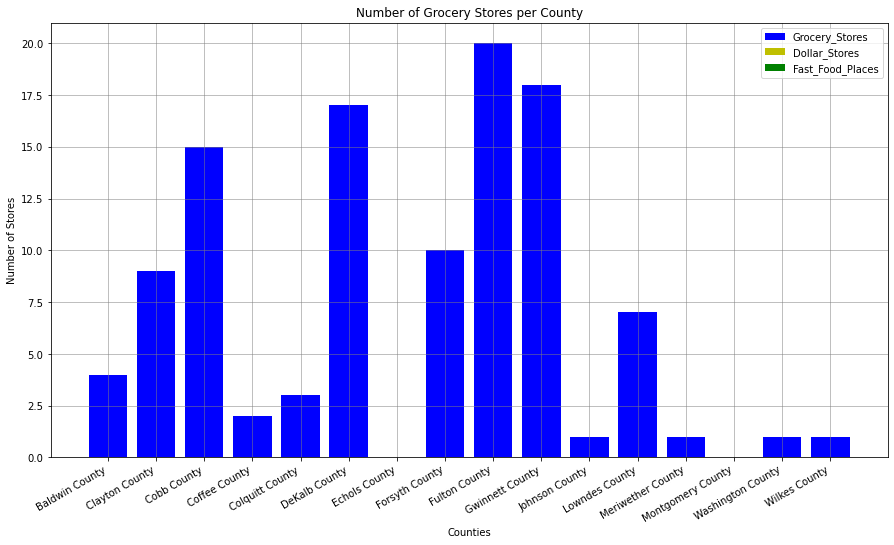

In [257]:
plt.rcParams["figure.figsize"] = (15,8)
width = .2
x_axis = np.arange(len(county_stores_df))


bar1 = plt.bar(x_axis, county_stores_df["Total_Grocery_Stores"], color='b')
 
plt.xticks(x_axis, county_stores_df["County_Name"],  rotation= 30, fontsize='10', horizontalalignment='right')
plt.xlabel("Counties")
plt.ylabel("Number of Stores")
plt.title("Number of Grocery Stores per County")
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.legend((bar1, bar2, bar3), ('Grocery_Stores', 'Dollar_Stores', 'Fast_Food_Places') )
plt.show()

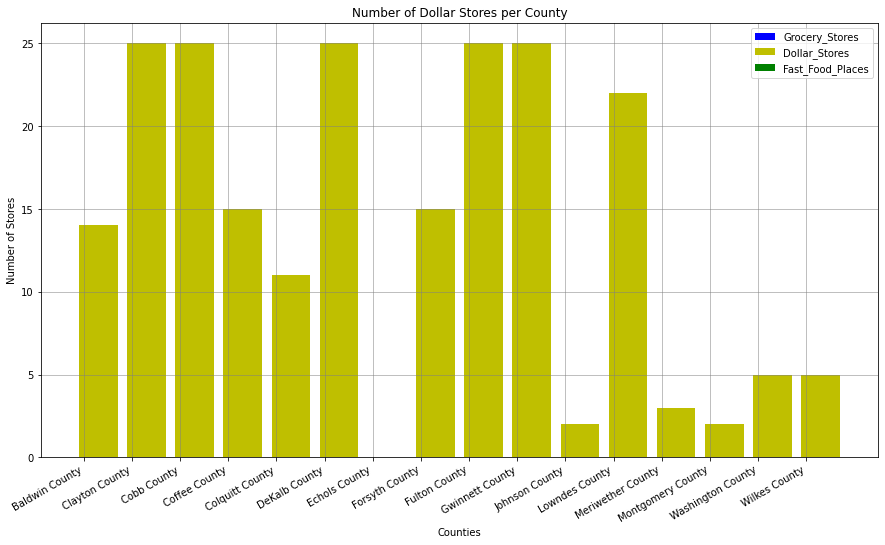

In [256]:
plt.rcParams["figure.figsize"] = (15,8)
width = .2
x_axis = np.arange(len(county_stores_df))


bar2 = plt.bar(x_axis+(width*1.5), county_stores_df["Total_Dollar_Stores"], color='y')
 
plt.xticks(x_axis, county_stores_df["County_Name"],  rotation= 30, fontsize='10', horizontalalignment='right')
plt.xlabel("Counties")
plt.ylabel("Number of Stores")
plt.title("Number of Dollar Stores per County")
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.legend((bar1, bar2, bar3), ('Grocery_Stores', 'Dollar_Stores', 'Fast_Food_Places') )
plt.show()

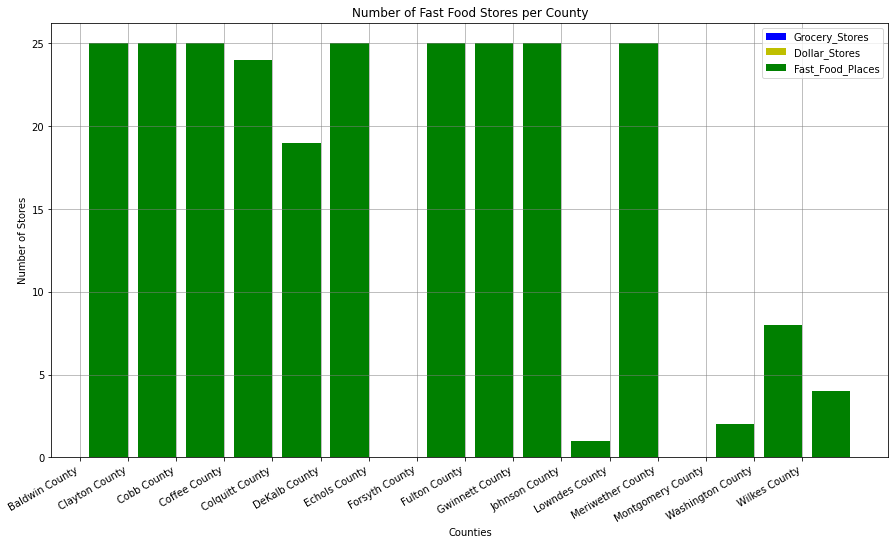

In [255]:
plt.rcParams["figure.figsize"] = (15,8)
width = .2
x_axis = np.arange(len(county_stores_df))


bar3 = plt.bar(x_axis+(width*3), county_stores_df["Total_Fast_Food_Places"], color='g')
 
plt.xticks(x_axis, county_stores_df["County_Name"],  rotation= 30, fontsize='10', horizontalalignment='right')
plt.xlabel("Counties")
plt.ylabel("Number of Stores")
plt.title("Number of Fast Food Stores per County")
plt.grid(color='grey', linewidth=1, axis='both', alpha=0.5)
plt.legend((bar1, bar2, bar3), ('Grocery_Stores', 'Dollar_Stores', 'Fast_Food_Places') )
plt.show()

In [154]:
# Plot Heatmap
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(coord, weights=grocery_stores, dissipating=False, max_intensity=50, point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [158]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Store</dt><dd>{Store_Name}</dd>
<dt>County</dt><dd>{County_Name}</dd>
</dl>
"""
# <dt>School</dt><dd>{School_Name}</dd>

# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
grocery_store_info = [info_box_template.format(**row) for index, row in grocery_stores_df.iterrows()]
locations = grocery_stores_df[["Store_Lat","Store_Long"]]

In [159]:
# Add marker layer ontop of heat map
fig = gmaps.figure()
marker_layer = gmaps.marker_layer(locations, info_box_content = grocery_store_info)

fig.add_layer(marker_layer)

# Display figure

fig

Figure(layout=FigureLayout(height='420px'))

In [156]:
coord = county_stores_df[["Latitude","Longitude"]]
dollar_stores = county_stores_df["Total_Dollar_Stores"]

In [157]:
# Plot Heatmap
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(coord, weights=dollar_stores, dissipating=False, max_intensity=50, point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [160]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Store</dt><dd>{Store_Name}</dd>
<dt>County</dt><dd>{County_Name}</dd>
</dl>
"""
# <dt>School</dt><dd>{School_Name}</dd>

# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
dollar_store_info = [info_box_template.format(**row) for index, row in dollar_stores_df.iterrows()]
locations = dollar_stores_df[["Store_Lat","Store_Long"]]

In [161]:
# Add marker layer ontop of heat map
fig = gmaps.figure()
marker_layer = gmaps.marker_layer(locations, info_box_content = dollar_store_info)

fig.add_layer(marker_layer)

# Display figure

fig

Figure(layout=FigureLayout(height='420px'))

In [162]:
coord = county_stores_df[["Latitude","Longitude"]]
Fast_Food_Places = county_stores_df["Total_Fast_Food_Places"]

In [163]:
# Plot Heatmap
figure_layout = {
    'width': '400px',
    'height': '300px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(coord, weights=Fast_Food_Places, dissipating=False, max_intensity=50, point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [102]:
# NOTE: Do not change any of the code in this cell

# Using the template add the hotel marks to the heatmap
info_box_template = """
<dl>
<dt>Store</dt><dd>{Store_Name}</dd>
<dt>County</dt><dd>{County_Name}</dd>
</dl>
"""
# <dt>School</dt><dd>{School_Name}</dd>

# Store the DataFrame Row
# NOTE: be sure to update with your DataFrame name
fastfood_info = [info_box_template.format(**row) for index, row in fastfoodplace_df.iterrows()]
locations = fastfoodplace_df[["Store_Lat","Store_Long"]]

In [103]:
# Add marker layer ontop of heat map
fig = gmaps.figure()
marker_layer = gmaps.marker_layer(locations, info_box_content = fastfood_info)

fig.add_layer(marker_layer)

# Display figure

fig


Figure(layout=FigureLayout(height='420px'))

In [164]:
output_grocery_store_file = "../Output/county_grocery_store_final.csv"
grocery_stores_df.to_csv(output_grocery_store_file, sep=',', index=False)

In [165]:
output_dollar_store_file = "../Output/county_dollar_store_final.csv"
dollar_stores_df.to_csv(output_dollar_store_file, sep=',', index=False)

In [166]:
output_fast_food_file = "../Output/county_fast_food_final.csv"
fastfoodplace_df.to_csv(output_fast_food_file, sep=',', index=False)

In [167]:
fastfoodplace_df.to_json('../Basic/resources/county_fast_food_final.json', orient = 'records', compression = 'infer')

In [168]:
grocery_stores_df.to_json('../Basic/resources/county_grocery_stores_final.json', orient = 'records', compression = 'infer')

In [169]:
dollar_stores_df.to_json('../Basic/resources/county_dollar_stores_final.json', orient = 'records', compression = 'infer')

In [170]:
output_county_stores_file = "../Output/county_stores_final.csv"
county_stores_df.to_csv(output_county_stores_file, sep=',', index=False)